In [10]:
import sys
sys.path.append('/Users/williiamlaplante/Research/SynchrotronMaps/code')
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import pandas as pd

from itertools import product

from tqdm.notebook import tqdm

from numba import njit

from ipywidgets import interact
import ipywidgets as widgets

from astropy.io import fits
from astropy.visualization import PercentileInterval, ZScaleInterval

from corrfunc import query_annulus, get_annuli_len
import concurrent.futures
from scipy.special import legendre
full_path_ref = '/Users/williiamlaplante/Research/SynchrotronMaps/data/ReferenceSamples/'
full_path_dust = '/Users/williiamlaplante/Research/SynchrotronMaps/data/DustMapsData/'

In [13]:
def compute_corr(map1, map2, R, dr, nest=False):

    if hp.get_nside(map1)!=hp.get_nside(map2):
        raise Exception('Maps are of two different resolutions.')
        
    #parameters
    nside = hp.get_nside(map1)
    npix = hp.nside2npix(nside) 
    resol = np.degrees(hp.nside2resol(nside))

    if dr < resol:
        dr = resol

    if R==0: 
        return (map1*map2).mean(), (map1*map2).std()/np.sqrt(npix)

    elif R<resol:
        R = resol

    ring_len = get_annuli_len(nside, R, dr, step=4, nest=nest)

    #Get the desired pixels and the vectors associated with them.
    pix1, pix2 = np.arange(npix)[map1!=hp.UNSEEN], np.arange(npix)[map2!=hp.UNSEEN]
    pix_inter =  np.intersect1d(pix1,pix2)
    X,Y,Z = hp.pix2vec(nside, pix_inter, nest=nest)
    
    def query_annulus_wrapper(vec):
        return query_annulus(map2, nside, vec, R, dr, nest).sum()/ring_len
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        arr = np.fromiter(executor.map(query_annulus_wrapper, zip(X,Y,Z)), dtype=np.float)
    
    result = map1[pix_inter] * arr
    return result.mean(), result.std()/np.sqrt(npix)


In [7]:
m = np.random.normal(size=hp.nside2npix(128))

In [9]:
%timeit compute_corr(m,m,5,1)

21.8 s ± 68.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
def _getparams(nside):
    if nside==256:
        #x = np.exp(np.linspace(-4.2, 0.8, 15))
        #x = np.concatenate((np.array([0]),np.exp(np.linspace(-0.5, 3, 11))))
        x = np.linspace(20,250,6)/60
        colors = ['red', 'pink', 'cyan', 'blue']
        dr = (x[1:] - x[:-1])
        dr = np.append(dr, dr[-1])
    else:
        raise Exception('params for this nside not completed yet.')
    
    return x, dr, colors

def plot_corr(dust_map, *ref_maps, scale='log'):
    
    x, dr, colors = _getparams(hp.get_nside(dust_map))
    
    plt.figure(figsize=(8,6))
    
    for ref_map, color in tqdm(zip(ref_maps, colors),total=len(ref_maps)):
        out = [compute_corr(ref_map, dust_map, R, thick) for R,thick in zip(x,dr)] 
        y,err = zip(*out)
        plt.errorbar(x*60, list(y), yerr=list(err), color=color)
        
    plt.xscale(scale)
    plt.xlabel('degrees (arcmin)')
    plt.ylabel('correlation')
    xmin, xmax = plt.xlim()
    plt.hlines(0, xmin, xmax, lw=0.5)
    return 

In [33]:
def f(x):
    print(x)

In [2]:
import time
'myfile.%d.dat' % time.time()

'myfile.1595436938.dat'

In [ ]:
'''
before:
out = [compute_corr(ref_dict[zrange], dust_map, r, thick) for r,thick in zip(x,thicknesses)]

after:
with concurrent.futures.ProcessPoolExecutor() as executor:
    args = ((ref_dict[zrange], dust_map, r, thick) for r, thick in zip(x,thicknesses))
    out = list(executor.map(lambda p:compute_corr(*args), args))




'''





In [3]:
@interact(theta = widgets.IntSlider(min=0, max=360, step=1, value=0, description='theta(position)'),
          phi = widgets.IntSlider(min=-90, max=90, step=1, value=10, description='phi(position)'),
          R = widgets.FloatSlider(min=0, max=10.0, step=0.2, value=2, description='R (degrees)'),
          dr_mult = widgets.IntSlider(min=1, max=50, step=1, value=6), description='dr multiplier')

def vis(theta, phi, R, dr_mult):
    '''
    visualization tool to see what the circles we are retrieving in the compute_cor(theta) function look like. Theta,
    phi, R are all in degrees, and dr_mult is a multiple of the resolution dr in degrees.
    
    '''
    
    #Getting some maps
    m = np.random.normal(size=hp.nside2npix(1024))
    m2 = m

    
    #Setting up parameters
    nside = hp.get_nside(m)
    vec = hp.ang2vec(theta, phi, lonlat=True)
    dr = dr_mult*np.degrees(hp.nside2resol(nside))

    #Retrieving the index of the circle
    index = query_annulus(m, nside, vec, R, dr, idx=True)
    
    #Retrieving statistical properties of values on circle
    mean, std = m[index].mean(), m[index].std()
    values = m[index]
    m[index] = m.max() 
    #Plotting everything
    zscale = ZScaleInterval()
    print('mean of values on annulus: '+ str(mean) + r' +- '+str(std/np.sqrt(len(index))))
    print('std of values on annulus: ' +str(std))
    print('length of annulus array values: '+str(len(index)))
    print('thickness of annuli : '+str(dr)+' degrees')
    plt.figure(figsize=(6,4))
    plt.hist(values, bins=45)
    plt.title('occurrence of values on circle')
    hp.mollview(zscale(m), title="NSIDE = "+str(nside))

    return

interactive(children=(IntSlider(value=0, description='theta(position)', max=360), IntSlider(value=10, descript…

# Tests

In [4]:
#using same bin width for 256, 512, 1024
#generate fields with healpix function hp.synfast and test corr_func with that
#compare results with corr func from legendre polynomials

#Results:

#Compute_corr gives same result for auto-correlation when using C_l technique. Different magnitude, but same shape


In [170]:
def C(theta, C_l):
    l_max=len(C_l)
    res=0
    for l in range(l_max):
        res+= C_l[l] * ((2*l + 1)/4*np.pi) * legendre(l)(np.cos(theta))
    return res



/Users/williiamlaplante/.local/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<ErrorbarContainer object of 3 artists>

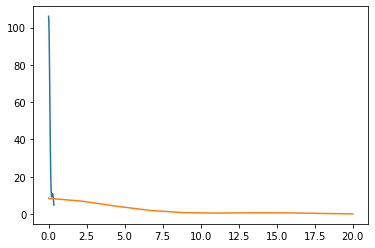

In [246]:


x = np.radians(np.linspace(0.01,20,100))
x2 = np.linspace(0.01,20,10)
thicknesses = np.append((x2[1:] - x2[:-1]), x2[-1]-x2[-2])
y = [C(theta,C_l) for theta in x]
out = [compute_corr(m,m,theta,thick) for theta,thick in zip(x2,thicknesses)]
y2,err = zip(*out)


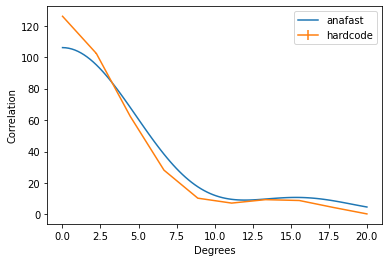

In [250]:
plt.plot(np.degrees(x),y,label='anafast')
plt.errorbar(x2,15*np.array(list(y2)),yerr=list(err),label='hardcode')
plt.xlabel('Degrees')
plt.ylabel('Correlation')
plt.legend()

In [5]:
def _plot(ax, ref_map, dust_map):
    
    resol = np.degrees(hp.nside2resol(hp.get_nside(ref_map)))
    dr = [resol*n for n in range(2,20)]
    
    values = []
    errors = []
    for thick in dr:
        x = np.arange(20/60,500/60,thick)
        out = [compute_corr(ref_map, dust_map, R, thick) for R in x]
        y, err = zip(*out)
        values.append(np.mean(y))
        errors.append(np.std(y)/np.sqrt(len(y)))
        
    ax.errorbar(dr,values,yerr=errors)
    ax.set_title('NSIDE='+str(hp.get_nside(ref_map)))
    ax.set_xlabel('thickness(degrees)')
    ax.set_ylabel('correlation')
    ax.grid()
    return 
    
def plotwrapper():
    nsides = [128,256]    
    figs, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,6))
    ref = generate_ref_maps(nsides[1])
    dust_map, _ = generate_dust_maps(nsides[1])
        
    for ax, ref_map in tqdm(zip(axes, list(ref)),total=len(ref)):
        _plot(ax, ref_map, dust_map)
    
    plt.savefig('temp/corr_vs_dr.jpg', format='jpeg')
    return 

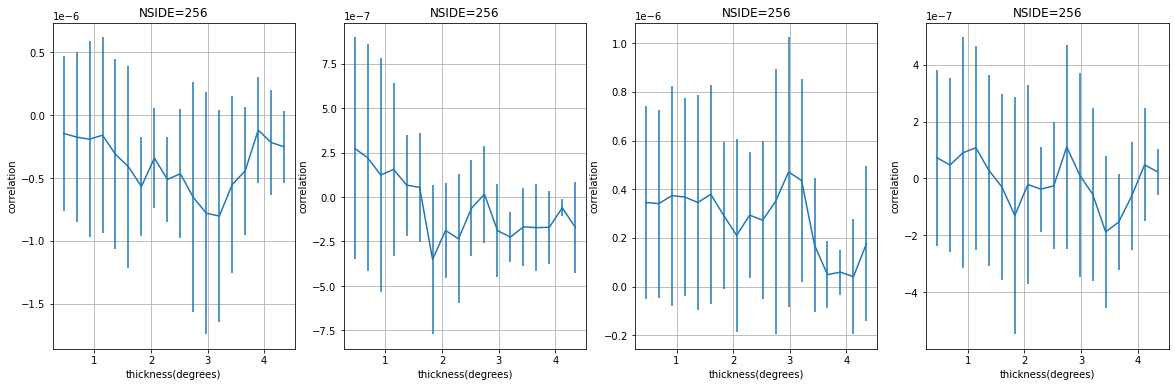

In [14]:
#test to see how average correlation over angle is affected by thickness of 
plotwrapper()

In [ ]:
#test for large dr, see if it gets closer and closer to 0

In [ ]:
#plot of correlation vs dr for different nside, for each of the reference maps

In [4]:
#upload to github!!!